## Liga MX's Top Shooters

This week I inspired my visual on [Jon Ollington's Next Fox in the Box](https://twitter.com/jonollington/status/1481556314702680068) visual.

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patheffects as path_effects
import matplotlib.font_manager as fm
import matplotlib.colors as mcolors
from matplotlib import cm
from highlight_text import fig_text, ax_text
from matplotlib.patches import RegularPolygon

# We'll only use a vertical pitch for this tutorial
from mplsoccer import VerticalPitch

from PIL import Image
import urllib
import os

In [17]:
font_path = "../assets/fonts"
for x in os.listdir(font_path):
    for y in os.listdir(f"{font_path}/{x}"):
        if y.split(".")[-1] == "otf":
            fm.fontManager.addfont(f"{font_path}/{x}/{y}")
            try:
                fm.FontProperties(weight=y.split("-")[-1].split(".")[0].lower(), fname=y.split("-")[0])
            except Exception:
                continue

plt.style.use("../assets/stylesheets/soc_base.mplstyle")
plt.rcParams['font.family'] = 'Nippo'

In [18]:
data = pd.read_csv('data/10172022_epl.csv', index_col=0)

First, we filter all penalty shots.

In [19]:
data = data[data['situation'] != 'Penalty'].reset_index(drop=True)
data

,teamId,playerId,playerName,min,xG,eventType,teamColor,match_id,isOwnGoal,x,y,situation,teamName
0,9825,576165,Gabriel Jesus,4,0.145418,AttemptSaved,#bd0510,3900932,False,93.000000,34.228749,RegularPlay,Arsenal
1,9825,1021586,Gabriel Martinelli,4,0.221315,Miss,#bd0510,3900932,False,98.824561,42.003750,RegularPlay,Arsenal
2,9825,623621,Oleksandr Zinchenko,8,0.030764,AttemptSaved,#bd0510,3900932,False,91.099998,46.663183,RegularPlay,Arsenal
3,9825,434325,Thomas Partey,9,0.095664,AttemptSaved,#bd0510,3900932,False,87.533822,38.032142,RegularPlay,Arsenal
4,9825,1021586,Gabriel Martinelli,20,0.155939,Goal,#bd0510,3900932,False,101.112070,32.475000,FromCorner,Arsenal
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2430,10260,696365,Marcus Rashford,82,0.042202,Miss,#9f1300,3901038,False,79.556798,44.421146,FreeKick,Manchester United
2431,10260,208494,Casemiro,84,0.008432,AttemptSaved,#9f1300,3901038,False,75.615050,30.492501,RegularPlay,Manchester United
2432,10260,322049,Fred,88,0.072295,Miss,#9f1300,3901038,False,96.122804,29.211429,RegularPlay,Manchester United
2433,10260,967622,Antony,90,0.025581,AttemptSaved,#9f1300,3901038,False,82.372332,22.527898,RegularPlay,Manchester United


Now, we check which are the players that had the most shots inside the box this season. 

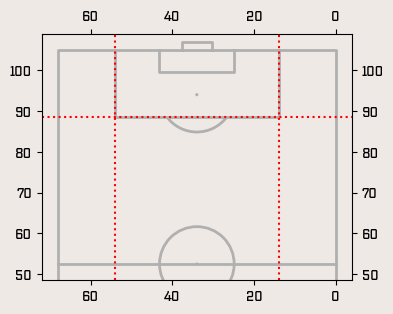

In [20]:
fig = plt.figure(figsize = (4,4), dpi = 100)
ax = plt.subplot(111)
pitch = VerticalPitch(
    pitch_type='uefa',
    half=True,
    axis=True, 
    label=True, 
    tick=True,
    goal_type='box'
)
pitch.draw(ax = ax)

ax.plot([13.84, 13.84], [ax.get_ylim()[0], ax.get_ylim()[1]], ls=':', color='red')
ax.plot([54.16, 54.16], [ax.get_ylim()[0], ax.get_ylim()[1]], ls=':', color='red')

ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [88.5,88.5], ls=':', color='red')

In [21]:
def is_inside_box(x,y):
    '''
    Checks if a shot lies within the dimensions of our box.
    '''
    if (x >= 13.84) & (x <= 54.16) & (y >=88.5):
        return True
    else:
        return False

In [22]:
# We invert the data because we're looking at a Vertical Pitch
data['is_in_box'] = [is_inside_box(x,y) for x,y in zip(data['y'], data['x'])]
data_groupped = data.groupby(['playerId', 'playerName', 'teamId', 'is_in_box'])['min'].count().reset_index()

In [23]:
data_groupped = data_groupped.pivot(columns='is_in_box', index=['playerId', 'playerName', 'teamId'], values='min').reset_index()
data_groupped.columns = ['playerId', 'playerName', 'teamId', 'False', 'True']
data_groupped.fillna(0, inplace=True)

In [24]:
data_groupped['total'] = data_groupped['False'] + data_groupped['True']
data_groupped['share'] = data_groupped['True']/data_groupped['total']

In [25]:
data_groupped = (
    data_groupped
    .sort_values(by='total', ascending=False)
    .head(6)
)
data_groupped

,playerId,playerName,teamId,False,True,total,share
215,737066,Erling Braut Haaland,8456,3.0,40.0,43.0,0.930233
42,194165,Harry Kane,8586,9.0,26.0,35.0,0.742857
92,351860,Aleksandar Mitrovic,9879,6.0,27.0,33.0,0.818182
160,576165,Gabriel Jesus,9825,0.0,31.0,31.0,1.000000
130,493165,James Maddison,8197,17.0,12.0,29.0,0.413793
52,212867,Heung-Min Son,8586,9.0,18.0,27.0,0.666667


We filter those players.

In [26]:
data = data[data['playerId'].isin(data_groupped['playerId'])].reset_index(drop=True)

## The Viz

First, we define the color map we'll be using.

In [27]:
colors = [
    '#d0d6d4',
    '#c5d0cd',
    '#bbcac7',
    '#b0c3c1',
    '#a6bdbb',
    '#9bb7b5',
    '#91b1af',
    '#86aaa8',
    '#7ca4a2',
    '#719e9c',
    '#679896',
    '#5c9190',
    '#528b8a',
    '#478583',
    '#3d7f7d',
    '#327877',
    '#287271',
]
soc_cm = mcolors.LinearSegmentedColormap.from_list('SOC', colors, N=50)
cm.register_cmap(name='SOC', cmap=soc_cm)

And the function to draw a semi circle

In [28]:
import numpy as np
# function for semicircle
def semicircle(r, h, k):
    x0 = h - r  # determine x start
    x1 = h + r  # determine x finish
    x = np.linspace(x0, x1, 10000)  # many points to solve for y

    # use numpy for array solving of the semicircle equation
    y = k - np.sqrt(r**2 - (x - h)**2)  
    return x, y

In [29]:
def plot_hexbin_shot(ax, playerId):

    pitch = VerticalPitch(
        pitch_type='uefa',
        half=True,
        goal_type='box',
        linewidth=1.25,
        line_color='black',
        pad_bottom=-8,
        pad_top=10
    )
    pitch.draw(ax = ax)

    aux_data = data[data['playerId'] == playerId]
    bins = pitch.hexbin(x=aux_data['x'], y=aux_data['y'], ax=ax, cmap='SOC', gridsize=(14,14), zorder=-1, edgecolors='#efe9e6', alpha=0.9, lw=.25)

    x_circle, y_circle = semicircle(104.8 - aux_data['x'].median(), 34, 104.8)  # function call
    ax.plot(x_circle, y_circle, ls='--', color='red', lw=.75)

    annot_x = [54 - x*14 for x in range(0,4)] 
    annot_texts = ['goals', 'xG', 'shots', 'xG/shot']
    annot_stats = [aux_data[aux_data['eventType'] == 'Goal'].shape[0], aux_data['xG'].sum(), aux_data.shape[0], aux_data['xG'].sum()/aux_data.shape[0]]
    for x,s,stat in zip(annot_x, annot_texts, annot_stats):
        hex_annotation = RegularPolygon((x, 70), numVertices=6, radius=4.5, edgecolor='black', fc='None', hatch='.........', lw=1.25)
        ax.add_patch(hex_annotation)
        ax.annotate(
            xy=(x,70),
            text=s,
            xytext=(0,-14),
            textcoords='offset points',
            size=5,
            ha='center',
            va='center'
        )
        if isinstance(stat, int):
            text_stat = f'{stat:.0f}'
        else:
            text_stat = f'{stat:.2f}'
        text_ = ax.annotate(
            xy=(x,70),
            text=text_stat,
            xytext=(0,0),
            textcoords='offset points',
            size=5,
            ha='center',
            va='center',
            weight='bold'
        )
        text_.set_path_effects(
            [path_effects.Stroke(linewidth=1.5, foreground='#efe9e6'), path_effects.Normal()]
        )

    # Draw the annotations at the top of the box.
    median_annotation = ax.annotate(
        xy=(34,110),
        xytext=(x_circle[-1], 110),
        text=f"{((105 - aux_data['x'].median())*18)/16.5:.1f} yds.",
        size=4,
        color='red',
        ha='right',
        va='center',
        arrowprops=dict(arrowstyle= '<|-, head_width=0.35, head_length=0.65',
            color='red',
            fc='#efe9e6',
            lw=0.75)
    )

    ax.annotate(
        xy=(34,110),
        xytext=(4,0),
        text=f"median distance",
        textcoords='offset points',
        size=4,
        color='red',
        ha='left',
        va='center',
        alpha=0.5
    )

    ax.annotate(
        xy=(34,114),
        text=f"{aux_data['playerName'].iloc[0].upper()}",
        size=7.5,
        color='black',
        ha='center',
        va='center',
        weight='bold'
    )

    return ax

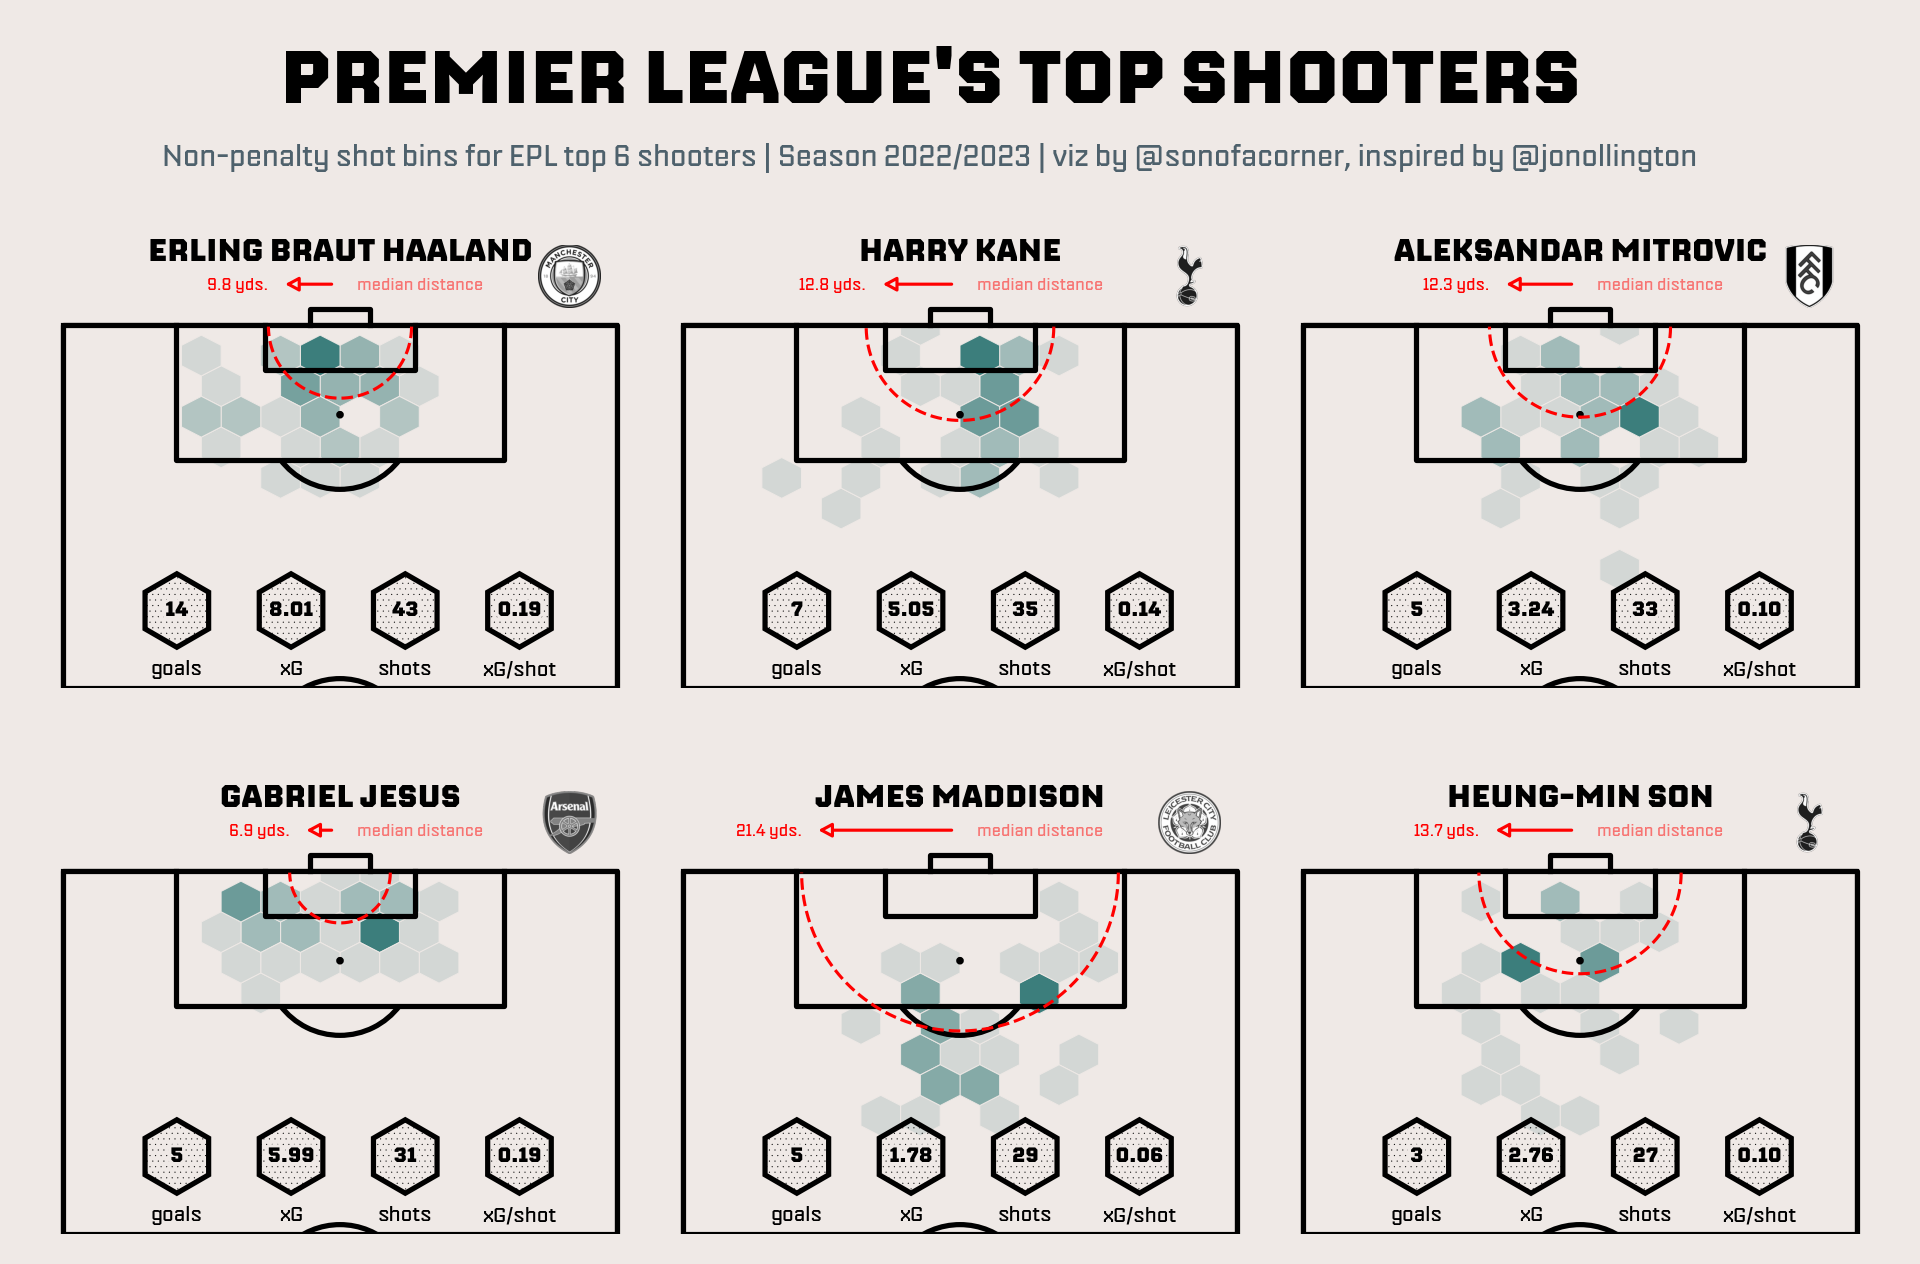

In [30]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(8,6), dpi=300)
axs = np.array(axs)
plt.rcParams['hatch.linewidth'] = .02
for index, ax in enumerate(axs.reshape(-1)):
    plot_hexbin_shot(ax, data_groupped['playerId'].iloc[index])

plt.subplots_adjust(wspace=0, hspace=-.35)
# We add the logos once we've reshaped the figure
for index, ax in enumerate(axs.reshape(-1)):
    # -- Transformation functions
    DC_to_FC = ax.transData.transform
    FC_to_NFC = fig.transFigure.inverted().transform
    # -- Take data coordinates and transform them to normalized figure coordinates
    DC_to_NFC = lambda x: FC_to_NFC(DC_to_FC(x))
    ax_coords = DC_to_NFC((11,98))
    ax_size = 0.035
    image_ax = fig.add_axes(
        [ax_coords[0], ax_coords[1], ax_size, ax_size],
        fc='None'
    )
    fotmob_url = 'https://images.fotmob.com/image_resources/logo/teamlogo/'
    club_icon = Image.open(urllib.request.urlopen(f'{fotmob_url}{data_groupped["teamId"].iloc[index]:.0f}.png')).convert('LA')
    image_ax.imshow(club_icon)
    image_ax.axis('off')


fig_text(
    x = 0.5, y = .84, 
    s = "PREMIER LEAGUE'S TOP SHOOTERS",
    va = "bottom", ha = "center",
    fontsize = 18, color = "black", font = "Nippo", weight = "bold"
)
fig_text(
	x = 0.5, y = .81, 
    s = "Non-penalty shot bins for EPL top 6 shooters | Season 2022/2023 | viz by @sonofacorner, inspired by @jonollington",
    # highlight_textprops=[{"weight": "bold", "color": "black"}],
	va = "bottom", ha = "center",
	fontsize = 7, color = "#4E616C", font = "Nippo"
)

plt.savefig(
	"figures/10172022_epl_shots.png",
	dpi = 600,
	facecolor = "#EFE9E6",
	bbox_inches="tight",
    edgecolor="none",
	transparent = False
)

plt.savefig(
	"figures/10172022_epl_shots_tr.png",
	dpi = 600,
	facecolor = "none",
	bbox_inches="tight",
    edgecolor="none",
	transparent = True
)